In [1]:
import pandas as pd
import sqlite3
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import lightgbm as lgb
import matplotlib.pyplot as plt

print("Bibliothèques importées avec succès.")

Bibliothèques importées avec succès.


In [ ]:
# CHARGEMENT DES DONNÉES ---
DB_PATH = '../data/support_tickets.db'
TABLE_NAME = 'tickets'
FEATURE_COLUMN = 'description'
TARGET_COLUMN = 'category'

conn = sqlite3.connect(DB_PATH)
query = f"SELECT {FEATURE_COLUMN}, {TARGET_COLUMN} FROM {TABLE_NAME}"
df = pd.read_sql_query(query, conn)
conn.close()

In [ ]:
# NETTOYAGE ET PRÉPARATION ---
df.dropna(subset=[FEATURE_COLUMN, TARGET_COLUMN], inplace=True)
category_counts = df[TARGET_COLUMN].value_counts()
categories_to_keep = category_counts[category_counts >= 2].index
df_filtered = df[df[TARGET_COLUMN].isin(categories_to_keep)]

X = df_filtered[FEATURE_COLUMN]
y = df_filtered[TARGET_COLUMN]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
#  DÉFINITION ET ENTRAÎNEMENT DU PIPELINE ---

print("Définition du pipeline...")
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))),
    ('clf', lgb.LGBMClassifier(random_state=42))
])

print("Entraînement du pipeline en cours...")
# La ligne .fit() est ce qui entraîne le modèle.
pipeline.fit(X_train, y_train)
print("Entraînement terminé !")

Définition du pipeline...
Entraînement du pipeline en cours...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.398282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 272442
[LightGBM] [Info] Number of data points in the train set: 15999, number of used features: 4960
[LightGBM] [Info] Start training from score -3.276707
[LightGBM] [Info] Start training from score -3.368547
[LightGBM] [Info] Start training from score -3.745387
[LightGBM] [Info] Start training from score -3.068240
[LightGBM] [Info] Start training from score -2.946880
[LightGBM] [Info] Start training from score -2.492624
[LightGBM] [Info] Start training from score -1.430445
[LightGBM] [Info] Start training from score -1.470157
[LightGBM] [Info] Start training from score -4.328423
[LightGBM] [Info] Start training from score -5.460774
[LightGBM] [Info] Start training from sc

In [ ]:
# ÉVALUATION ---
print("\nÉvaluation du modèle sur l'ensemble de test...")
y_pred = pipeline.predict(X_test)
print("Rapport de classification :\n")
print(classification_report(y_test, y_pred))


Évaluation du modèle sur l'ensemble de test...


c:\Users\pc\anacond\envs\mon_env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Rapport de classification :

                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.56      0.52      0.54       151
                                                 Checking or savings account       0.59      0.51      0.55       138
                                                               Consumer Loan       0.48      0.32      0.38        95
                                                                 Credit card       0.54      0.49      0.51       186
                                                 Credit card or prepaid card       0.56      0.49      0.52       210
                                                            Credit reporting       0.58      0.36      0.44       331
Credit reporting, credit repair services, or other personal consumer reports       0.66      0.79      0.72       957
                          

c:\Users\pc\anacond\envs\mon_env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\pc\anacond\envs\mon_env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\pc\anacond\envs\mon_env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [ ]:
#  SAUVEGARDE ---
PIPELINE_PATH = 'ticket_classifier_pipeline.pkl'
print(f"\nSauvegarde du pipeline entraîné dans : {PIPELINE_PATH}")
with open(PIPELINE_PATH, 'wb') as f:
    pickle.dump(pipeline, f)
print("Sauvegarde terminée avec succès.")


Sauvegarde du pipeline entraîné dans : ticket_classifier_pipeline.pkl
Sauvegarde terminée avec succès.


"Mon premier modèle LightGBM a atteint une accuracy de 70%. En analysant le rapport de classification, j'ai constaté qu'il était extrêmement performant sur des catégories bien définies comme les prêts immobiliers (f1-score de 89%), mais qu'il échouait sur des catégories rares ou sémantiquement ambiguës.


Pour améliorer ce score, les prochaines étapes seraient :



1. Regrouper les classes : Fusionner des catégories similaires et rares comme Payday loan, Consumer Loan et Vehicle loan en une seule méta-catégorie Personal Loan pour donner plus de données au modèle.
2. Utiliser des embeddings plus puissants : Au lieu de TF-IDF, je pourrais utiliser un modèle de type BERT (comme celui de Sentence-Transformers) pour générer des embeddings qui capturent mieux le contexte sémantique et aident à différencier les types de prêts.
3. Collecter plus de données : Pour les classes les plus rares, la seule solution à long terme est d'obtenir plus d'exemples."

In [7]:
# Création des Embeddings

from sentence_transformers import SentenceTransformer

# Charger un modèle pré-entraîné. 'all-MiniLM-L6-v2'.
print("Chargement du modèle SentenceTransformer...")
embedder = SentenceTransformer('all-MiniLM-L6-v2')

# Créer les embeddings pour l'ensemble de nos descriptions.
print("Création des embeddings pour toutes les descriptions de tickets...")
X_embeddings = embedder.encode(X.tolist(), show_progress_bar=True)

print("Création des embeddings terminée.")
print("Dimension de nos nouvelles features :", X_embeddings.shape)

c:\Users\pc\anacond\envs\mon_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Chargement du modèle SentenceTransformer...
Création des embeddings pour toutes les descriptions de tickets...


Batches: 100%|██████████| 625/625 [26:45<00:00,  2.57s/it]  


Création des embeddings terminée.
Dimension de nos nouvelles features : (19999, 384)


In [8]:
#  Division des Embeddings et Entraînement

# Diviser les embeddings et les étiquettes
X_train_emb, X_test_emb, y_train, y_test = train_test_split(
    X_embeddings, y, test_size=0.2, random_state=42, stratify=y
)

# Créer et entraîner le classifieur LightGBM directement sur les embeddings
print("\nEntraînement du classifieur LightGBM sur les embeddings...")
classifier_emb = lgb.LGBMClassifier(random_state=42)
classifier_emb.fit(X_train_emb, y_train)
print("Entraînement terminé !")


Entraînement du classifieur LightGBM sur les embeddings...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.122055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 97920
[LightGBM] [Info] Number of data points in the train set: 15999, number of used features: 384
[LightGBM] [Info] Start training from score -3.276707
[LightGBM] [Info] Start training from score -3.368547
[LightGBM] [Info] Start training from score -3.745387
[LightGBM] [Info] Start training from score -3.068240
[LightGBM] [Info] Start training from score -2.946880
[LightGBM] [Info] Start training from score -2.492624
[LightGBM] [Info] Start training from score -1.430445
[LightGBM] [Info] Start training from score -1.470157
[LightGBM] [Info] Start training from score -4.328423
[LightGBM] [Info] Start training from score -5.460774
[LightGBM] [Info] Start training from score -1.969628
[LightGBM] [Info] Start training from score -7.734371
[

c:\Users\pc\anacond\envs\mon_env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Rapport de classification (avec Embeddings + LightGBM) :

                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.34      0.31      0.33       151
                                                 Checking or savings account       0.33      0.27      0.30       138
                                                               Consumer Loan       0.19      0.12      0.14        95
                                                                 Credit card       0.41      0.26      0.32       186
                                                 Credit card or prepaid card       0.39      0.30      0.34       210
                                                            Credit reporting       0.47      0.19      0.27       331
Credit reporting, credit repair services, or other personal consumer reports       0.61      0.64      0.62       9

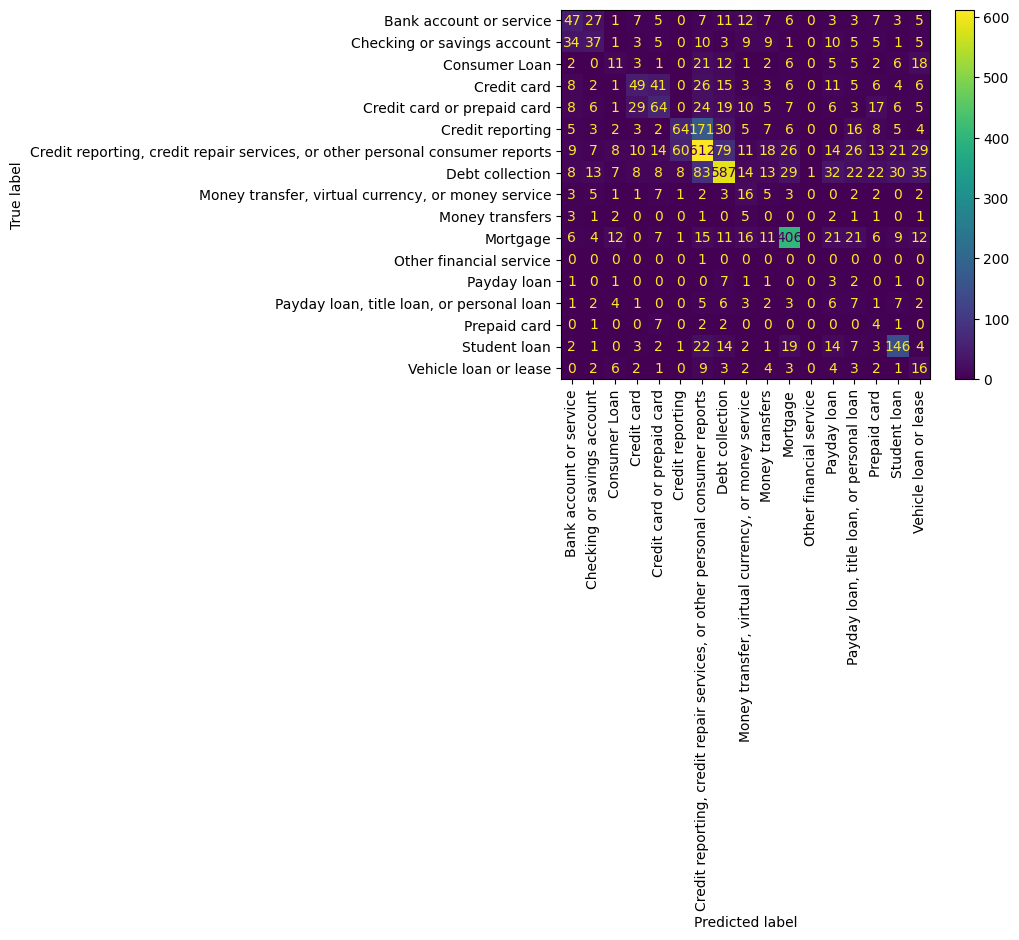

In [9]:
#  Évaluation du nouveau modèle

# Faire des prédictions sur l'ensemble de test
y_pred_emb = classifier_emb.predict(X_test_emb)

# Afficher le nouveau rapport de classification
print("Rapport de classification (avec Embeddings + LightGBM) :\n")
print(classification_report(y_test, y_pred_emb))

# Afficher la nouvelle matrice de confusion
print("\nMatrice de confusion (avec Embeddings + LightGBM) :")
cm_emb = confusion_matrix(y_test, y_pred_emb, labels=classifier_emb.classes_)
disp_emb = ConfusionMatrixDisplay(confusion_matrix=cm_emb, display_labels=classifier_emb.classes_)
disp_emb.plot(xticks_rotation='vertical')
plt.show()

In [10]:
#Sauvegarde du pipeline
PIPELINE_PATH = 'ticket_classifier_embeddings.pkl'
with open(PIPELINE_PATH, 'wb') as f:
    pickle.dump(pipeline, f)
print(f"Le pipeline a été sauvegardé avec succès dans : {PIPELINE_PATH}")

Le pipeline a été sauvegardé avec succès dans : ticket_classifier_embeddings.pkl


In [11]:
# Préparation des Données pour le Réseau de Neurones

from sklearn.preprocessing import LabelEncoder
import numpy as np

# Encoder les étiquettes textuelles en nombres
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Garder une trace des classes pour plus tard
class_names = encoder.classes_
print("Exemple d'étiquettes encodées :", y_encoded[:5])
print("Nombre de classes :", len(class_names))

# Diviser les embeddings et les étiquettes encodées
X_train_emb, X_test_emb, y_train_enc, y_test_enc = train_test_split(
    X_embeddings, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

Exemple d'étiquettes encodées : [16 10  5  5  6]
Nombre de classes : 17


In [12]:
#Construction du Modèle de Réseau de Neurones

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Définir l'architecture du modèle
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_emb.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(class_names), activation='softmax')
])

# Compiler le modèle
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)


model.summary()

c:\Users\pc\anacond\envs\mon_env\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 17)             │         1,105 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,641 (229.07 KB)

 Trainable params: 58,641 (229.07 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Entraînement du Réseau de Neurones

print("Entraînement du réseau de neurones en cours...")
history = model.fit(
    X_train_emb,
    y_train_enc,
    epochs=10,           
    batch_size=32,       
    validation_split=0.1 
)
print("Entraînement terminé !")

Entraînement du réseau de neurones en cours...
Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5102 - loss: 1.5654 - val_accuracy: 0.6269 - val_loss: 1.1255
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6126 - loss: 1.1712 - val_accuracy: 0.6306 - val_loss: 1.0554
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6268 - loss: 1.0963 - val_accuracy: 0.6438 - val_loss: 0.9970
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6391 - loss: 1.0421 - val_accuracy: 0.6444 - val_loss: 0.9587
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6412 - loss: 1.0151 - val_accuracy: 0.6587 - val_loss: 0.9373
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6523 - loss: 0.9874 - val_accuracy: 0.6562 - val_loss: 0.9299
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6560 - loss: 0.9666 - val_accuracy: 0.6600 - val_loss: 0.9276
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - acc

In [14]:
# Évaluation et Sauvegarde

# Évaluation sur l'ensemble de test
loss, accuracy = model.evaluate(X_test_emb, y_test_enc)
print(f"\nPerformance sur l'ensemble de test : Accuracy = {accuracy:.4f}")

# Faire des prédictions pour le rapport de classification
y_pred_proba = model.predict(X_test_emb)
y_pred_enc = np.argmax(y_pred_proba, axis=1) # Prendre la classe avec la plus haute probabilité

# Décoder les prédictions pour avoir les noms des classes
y_pred_labels = encoder.inverse_transform(y_pred_enc)
y_test_labels = encoder.inverse_transform(y_test_enc)

# Afficher le rapport de classification
print("\nRapport de classification (avec Réseau de Neurones) :\n")
print(classification_report(y_test_labels, y_pred_labels))

# Sauvegarder le modèle Keras et l'encodeur d'étiquettes
model.save('ticket_classifier_nn.keras')
with open('ticket_label_encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)

print("\nModèle de réseau de neurones ('ticket_classifier_nn.keras') et encodeur ('ticket_label_encoder.pkl') sauvegardés.")

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6725 - loss: 0.9195

Performance sur l'ensemble de test : Accuracy = 0.6725
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Rapport de classification (avec Réseau de Neurones) :

                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.41      0.48      0.45       151
                                                 Checking or savings account       0.45      0.36      0.40       138
                                                               Consumer Loan       0.35      0.15      0.21        95
                                                                 Credit card       0.48      0.34      0.40       186
                                                 Credit card or prepaid card       0.40      0.50      0.44       210
                                                            Cre

c:\Users\pc\anacond\envs\mon_env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\pc\anacond\envs\mon_env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\pc\anacond\envs\mon_env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



Modèle de réseau de neurones ('ticket_classifier_nn.keras') et encodeur ('ticket_label_encoder.pkl') sauvegardés.
